In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import  DataLoader,SubsetRandomSampler 
import torch.optim as optim # Optimization package
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

<p> helper functions and classes </p>

In [3]:
def see_data_stored(data_from_customDataFunction):
  x = print('\nFirst iteration of data set: ', next(iter(data_from_customDataFunction)), '\n') # Display text and label.
  y =print('Length of data set: ', len(data_from_customDataFunction), '\n')                  # Print how many items are in the data set
  #z = print('Entire data set: ', list(DataLoader(data_from_customDataFunction)), '\n')        # Print entire data set
  return x,y

### Prepare data

<p> LOAD LALONDE DATASET </p>

In [5]:
'''
Load the two datasets.
nsw = Male sub sample of treated and control units as used by Lalonde.
nswre74  = Further subsample extracted by Dehejia and Wahba (1999) which includes information on earnings in 1974 (re74)

'''
nsw = pd.read_csv("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nsw_featureTransformed.csv")
nswre74 = pd.read_csv("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_featureTransformed.csv")

#Shuffle data sets 
nswre74_pd_df = shuffle(nswre74).reset_index(drop=True)
nsw_pd_df = shuffle(nsw).reset_index(drop=True)


<P> LOAD SIMULATED DATASET</P>

In [38]:
simulated_dataset = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/simulated_experimental_dataset.csv')
simulated_dataset.drop('Unnamed: 0', axis=1, inplace=True)

#### Data pre-processing for NN 

In [6]:
# Subset dataset for ANN training 
nsw_subset1 = ['treat','ageboxcox','education','black','hispanic','married','nodegree','lnre75','lnre78']
nswre74_subset1 = ['treat','ageboxcox','education','black','hispanic','married','nodegree','lnre74','lnre75','lnre78']

nsw_pd_df = nsw_pd_df[nsw_subset1]
nswre74_pd_df= nswre74_pd_df[nswre74_subset1]
nswre74_pd_df

,treat,ageboxcox,education,black,hispanic,married,nodegree,lnre74,lnre75,lnre78
0,1,0.908137,11,1,0,1,1,0.000000,0.000000,0.000000
1,1,0.903700,11,0,0,0,1,0.000000,0.000000,6.954639
2,1,0.895394,11,1,0,0,1,6.754900,5.365976,6.834109
3,0,0.917927,11,0,1,0,1,8.602221,8.027150,7.188413
4,1,0.892684,8,1,0,0,1,0.000000,0.000000,8.994793
...,...,...,...,...,...,...,...,...,...,...
359,0,0.905312,11,1,0,0,1,0.000000,0.000000,0.000000
360,1,0.899976,12,1,0,0,0,0.000000,0.000000,0.000000
361,0,0.899976,10,1,0,0,1,0.000000,0.000000,7.608374
362,0,0.901930,14,1,0,0,0,0.000000,0.000000,8.661294


In [7]:
nsw_continuos_vars = ['ageboxcox','education','lnre75','lnre78'] 
nswre74_continuos_vars = ['ageboxcox','education','lnre74','lnre75','lnre78'] 

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# Standardize continous variables 
nsw_pd_df[nsw_continuos_vars] = sc.fit_transform(nsw_pd_df[nsw_continuos_vars])
nswre74_pd_df[nswre74_continuos_vars] = sc.fit_transform(nswre74_pd_df[nswre74_continuos_vars])
# Select variables for ML model 

# Original lalonde (1986) sample 
features_noRe74_df = nsw_pd_df.drop('treat', axis=1)
target_noRe74_df = nsw_pd_df.iloc[:,0]

features_noRe74_array = np.array(features_noRe74_df)
target_noRe74_array = np.array(target_noRe74_df)

FEATURES_noRe74 = torch.tensor(features_noRe74_array)
TARGET_noRe74 = torch.tensor(target_noRe74_array).unsqueeze(1)

# Dehejia and wahba (1999) sample 
features_df = nswre74_pd_df.drop('treat', axis=1)
target_df = nswre74_pd_df.iloc[:,0]

features_array = np.array(features_df)
target_array = np.array(target_df)

FEATURES_Re74 = torch.tensor(features_array)
TARGET_Re74 = torch.tensor(target_array).unsqueeze(1)
print(features_noRe74_array.shape,target_noRe74_df.shape)

(664, 8) (664,)


#### Custom class for datasets

In [9]:
class CustomDataset:
  def __init__(self,features,target):    
    # load data
    self.features = features             
    self.target = target                
  
  def __len__(self):
    """
    Returns length of dataset.
    """

    return len(self.features)

  def __getitem__(self,idx):

    """
    Returns features and target with index idx.
    """
  
    features = self.features[idx]
    target = self.target[idx]
    return (features, target)
 

In [45]:
class CustomDataset:
  def __init__(self,features,target):    
    
    #import features and targets  
    self.features = features              
    self.target = target               
  
  def __len__(self):
    """
    Returns length of the dataset.
    """
    return len(self.features)

  def __getitem__(self,idx):
    """
    Returns features and target with index idx.
    """
    features = self.features[idx]
    target = self.target[idx]

    # convert data to array
    features_array = np.array(features)
    target_array = np.array(target)
    #convert to tensor 
    features = torch.tensor(features_array).float()
    target = torch.tensor(target_array).float()
    
    return (features, target)

####  Construct NN

<p> set hyper parameters </p>

### Model 

In [10]:
# Define neural netowork class 
class threelayerNN(nn.Module):
    def __init__(self, num_features, num_classes, num_hidden_1, num_hidden_2,num_hidden_3,num_hidden_4,num_hidden_5):
        super(threelayerNN, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.hidden_layer2 =  nn.Linear(num_hidden_2, num_hidden_3) 
        self.hidden_layer3 =  nn.Linear(num_hidden_3, num_hidden_4) 
        self.hidden_layer4 =  nn.Linear(num_hidden_4, num_hidden_5)
        self.hidden_layer5 =  nn.Linear(num_hidden_5, num_classes) 
    
        # Activation functions
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.3)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        self.batchnorm3 = nn.BatchNorm1d(num_hidden_3)
        self.batchnorm4 = nn.BatchNorm1d(num_hidden_4)
        self.batchnorm5 = nn.BatchNorm1d(num_hidden_5)
    
    # Forward propogation method
    def forward(self, x):
        # input 
        x = self.input_layer(x)
        x = self.relu_activation(x)
        x = self.batchnorm1(x)
        x = self.dropout(x)
        # first hidden layer
        x = self.hidden_layer1(x)
        x = self.relu_activation(x)
        x = self.batchnorm2(x)
        x = self.dropout(x)
        # second hidden layer and output
        x = self.hidden_layer2(x)
        x = self.relu_activation(x)
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.hidden_layer3(x)
        x = self.relu_activation(x)
        x = self.batchnorm4(x)
        x = self.dropout(x)
        x = self.hidden_layer4(x)
        x = self.relu_activation(x)
        x = self.batchnorm5(x)
        x = self.dropout(x)
        x = self.hidden_layer5(x)
        x = self.output_activation(x)
        return x


class twoLayerNN(nn.Module):
    def __init__(self,num_features, num_classes, num_hidden_1, num_hidden_2):
        super(twoLayerNN, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation functions
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.3)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)

    # Forward propogation method
    def forward(self, inputs):
        x = self.relu_activation(self.input_layer(inputs))
        x = self.batchnorm1(x)
        x = self.relu_activation(self.hidden_layer1(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.output_activation(self.out_layer(x))
        return x

    def compute_l1_loss(self, w):
      return torch.abs(w).sum()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")





<p> NN helper functions </p>

In [11]:
# Function to reset model weights 
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    #print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [12]:
# Function to initialise model weights 
def initialize_weights(m):
    classname = m.__class__.__name__
    # For every linear layer in the mdoel   
    if classname.find('Linear') != -1:
     n = m.in_features
     y = 1.0/np.sqrt(n)
     m.weight.data.uniform_(-y, y)
     m.bias.data.fill_(0)
    

### K-fold cross validation

<p> Initial settings <p>

In [64]:
from sklearn.model_selection import StratifiedKFold
from torchsampler import ImbalancedDatasetSampler
# Set model hyper parameters 
NUM_FEATURES = FEATURES_noRe74.shape[1]
NUM_HIDDEN_1 = 5
NUM_HIDDEN_2 = 5
NUM_HIDDEN_3 = 15
NUM_HIDDEN_4 = 15 
NUM_HIDDEN_5 = 15          
NUM_CLASSES = 1
NUM_EPOCHS = 1000
BATCH_SIZE =  64

LEARNING_RATE = 0.001

# training configuration options  
K_FOLDS = 5     
splits = KFold(n_splits=K_FOLDS,shuffle=True,random_state=42)

In [65]:
# Dictionaries to store results  
validation_accuracy_dict = {}      
validation_loss_dict = {}
training_accuracy_dict = {}
training_loss_dict = {}
foldperf = {}
acc_per_epoch = {}
fold_validation_accuracy = {}


### K-FOLD Cross validation 

In [68]:
dataset = CustomDataset(features = FEATURES_noRe74,target = TARGET_noRe74)

In [69]:
# set seed
torch.manual_seed(1)
print("==========  start =============")  
for fold, (train_ids, test_ids) in enumerate(splits.split(np.arange(len(dataset)))):    
#for fold, (train_ids, test_ids) in enumerate(splits.split(FEATURES_noRe74,TARGET_noRe74)):

    """  
    Sample elements randomly from a given list of ids, no replacement.

    """
    
    train_subsampler = SubsetRandomSampler(train_ids)
    test_subsampler = SubsetRandomSampler(test_ids)
    # Define data loaders for training and testing data in this fold
    
    trainloader = DataLoader(dataset,  batch_size=BATCH_SIZE, sampler=train_subsampler)
    testloader = DataLoader(dataset,batch_size=BATCH_SIZE, sampler=test_subsampler)

    # Instanstiate model 
    #model = threelayerNN(num_features = NUM_FEATURES,num_classes  = NUM_CLASSES, num_hidden_1 = NUM_HIDDEN_1,num_hidden_2 = NUM_HIDDEN_2,num_hidden_3 = NUM_HIDDEN_3,
    #num_hidden_4 = NUM_HIDDEN_4,num_hidden_5 = NUM_HIDDEN_5)
    model = twoLayerNN(num_features = NUM_FEATURES,num_classes  = NUM_CLASSES, num_hidden_1 = NUM_HIDDEN_1,num_hidden_2 = NUM_HIDDEN_2)
    model.to(device)
    # Reset weights 
    model.apply(reset_weights)
    model.apply(initialize_weights)
    #Initialise optimiser and loss function 
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()

    metrics = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    # Run training over nuber of epochs  
    for epoch in range(0, NUM_EPOCHS):
        # Training variables 
        running_training_loss = 0.0
        total_training_samples = 0 
        train_correct = 0
        train_accuracy = 0
        total_validation_samples = 0 
        running_validation_loss = 0.0
        val_correct = 0
        validation_acc = 0
        #set model to training mode
        model.train()
        print('==========  Training ==========') 
        for idx, (features,target) in enumerate(trainloader,start = 0):       # Iterate over the DataLoader for training data

            # GET DATA  
            target_tensor = target
            train_features = features.float().to(device)
            train_target = target.float().to(device)
            train_outputs = model(train_features)
            # COMPUTE LOSS
            loss = criterion(train_outputs , train_target)

             # ZERO PARAMETER GRADIENTS  
            optimizer.zero_grad()
            loss.backward()
            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # ========== TRAINING LOG ========== #

            #calculate training accuracy
            # At the completion of each epoch , store train losses 
            train_prediction = (train_outputs >= 0.5).type(torch.uint8) 
            running_training_loss += loss.item()*train_features.size(0)
            train_correct += (train_prediction == train_target).numpy().sum()
 
            if epoch == NUM_EPOCHS:
                # Save the model afer each fold 
                save_path = f'/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/ANN models/model-fold-{fold}.pth'
                #torch.save(model.state_dict(), '/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/k_cross_ANN.pt')
                torch.save(model.state_dict(), save_path)
        
        # STORE AND LOG TRAINING INFORMATION
        train_accuracy = train_correct/len(trainloader.sampler)*100
        training_accuracy_dict[(fold,epoch)] = train_accuracy.item()
        avg_loss = running_training_loss / len(trainloader.sampler)
        training_loss_dict[(fold,epoch)] = avg_loss
        print(f'Fold: {fold}'f' | Epoc: {epoch+1}/{NUM_EPOCHS} 'f' | Training Loss: {avg_loss:.4f}'f'| Training accuracy: {train_accuracy:.2f}')
    
        # Evaluate the model 
        with torch.no_grad():
            model.eval()
            print('==========  Validating ==========') 
            for idx, (features,target) in enumerate(testloader): # Iterate over the test data and generate predictions
                
                val_features = features.float().to(device)
                val_targets = target.float().to(device) 
                val_outputs = model(val_features)

                loss_validation = criterion(val_outputs , val_targets)

                # ========== VALIDATION LOG ========== # 

                prediction = (val_outputs >= 0.5).type(torch.uint8) 
                running_validation_loss += loss_validation.item()*val_features.size(0)
                val_correct += (prediction == val_targets).numpy().sum()

            # STORE AND LOG VALIDATION INFORMATION 
            validation_acc = val_correct/len(testloader.sampler)*100
            validation_accuracy_dict[(fold,epoch)]  = validation_acc.item()
            avg_val_loss = running_validation_loss / len(testloader.sampler)
            validation_loss_dict[(fold,epoch)] = avg_val_loss
            print(f'Fold: {fold}'f' | Epoc: {epoch+1}/{NUM_EPOCHS} | Valid Loss: {avg_val_loss:.2f}'f'| Validation accuracy: {validation_acc:.2f}')
            # * * * * * * * * * * * * * * * * * * * * * * * * * * * * 



validation_accuracy_list = list(validation_accuracy_dict.values())
average_validation_acc = np.sum(validation_accuracy_list)/len(validation_accuracy_list)
training_accuracy_list = list(training_accuracy_dict.values())
average_training_acc = np.sum(training_accuracy_list)/len(training_accuracy_list)

print(f'K-FOLD CROSS VALIDATION RESULTS FOR {K_FOLDS} FOLDS')

print(f'AVG valdiation acc: {average_validation_acc:.2f}| 'f'AVG training acc: {average_training_acc:.2f}')


==========  start =============
==========  Training ==========
Fold: 0 | Epoc: 1/1000  | Training Loss: 0.7801| Training accuracy: 50.63
==========  Validating ==========
Fold: 0 | Epoc: 1/1000 | Valid Loss: 0.74| Validation accuracy: 52.52
==========  Training ==========
Fold: 0 | Epoc: 2/1000  | Training Loss: 0.7808| Training accuracy: 50.09
==========  Validating ==========
Fold: 0 | Epoc: 2/1000 | Valid Loss: 0.74| Validation accuracy: 51.80
==========  Training ==========
Fold: 0 | Epoc: 3/1000  | Training Loss: 0.7775| Training accuracy: 50.81
==========  Validating ==========
Fold: 0 | Epoc: 3/1000 | Valid Loss: 0.74| Validation accuracy: 53.24
==========  Training ==========
Fold: 0 | Epoc: 4/1000  | Training Loss: 0.7778| Training accuracy: 50.81
==========  Validating ==========
Fold: 0 | Epoc: 4/1000 | Valid Loss: 0.74| Validation accuracy: 51.80
==========  Training ==========
Fold: 0 | Epoc: 5/1000  | Training Loss: 0.7726| Training accuracy: 53.16
==========  Validating

In [668]:
validation_acc = list(validation_accuracy_dict.values())
average_validation_acc = np.sum(validation_acc)/len(validation_acc)
training_acc = list(training_accuracy_dict.values())
average_validation_acc = np.sum(training_acc)/len(training_acc)

### Plot training summary 

In [70]:
# Convert accuracy and loss dictionaries to lists 
validation_accurary_list = list(validation_accuracy_dict.values())
validation_loss_list = list(validation_loss_dict.values())
training_accuracy_list = list(training_accuracy_dict.values())
training_loss_list = list(training_loss_dict.values())

<function matplotlib.pyplot.show(close=None, block=None)>

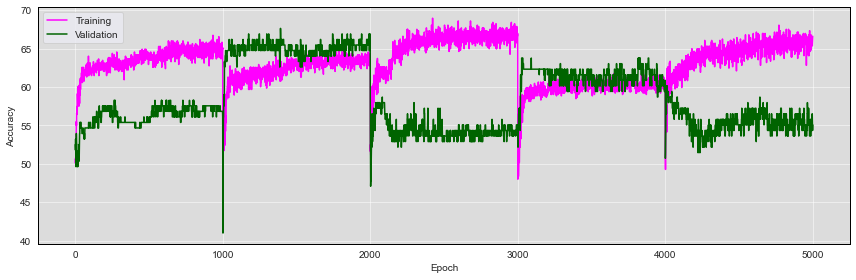

In [71]:
fig, ax = plt.subplots(figsize=(12,4))

ax.set_facecolor('gainsboro')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='white', axis='x', linestyle='-', linewidth=1, alpha=0.5)
ax.grid(color='white', axis='y', linestyle='-', linewidth=1, alpha=0.5)

epochs_train = len(training_accuracy_list)
epochs_val = len(validation_accurary_list)

plt.plot(np.arange(1, epochs_train+1),training_accuracy_list, label='Training',color='magenta')
plt.plot(np.arange(1, epochs_val+1),validation_accurary_list, label='Validation',color='darkgreen')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

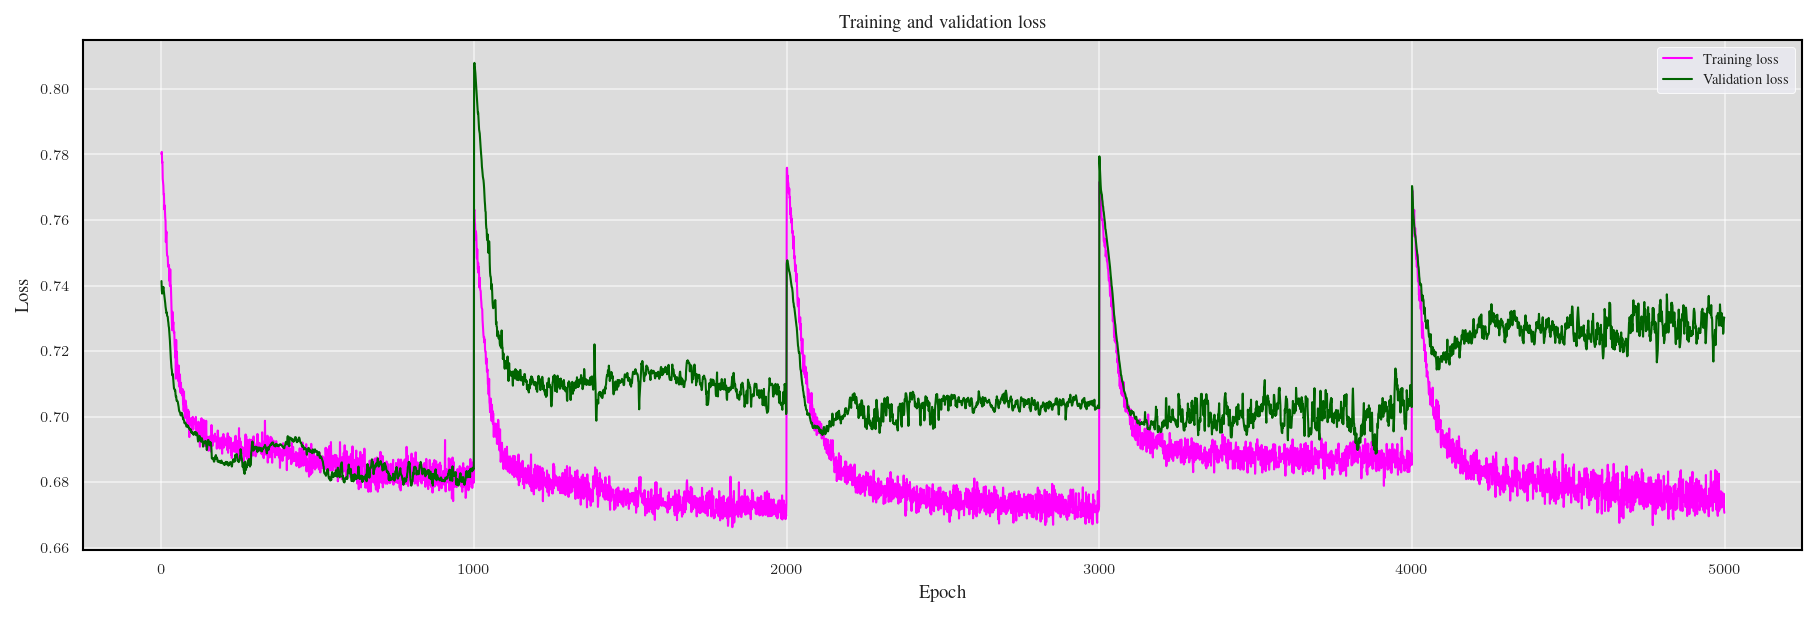

In [72]:
# Plot training and validation losses 

# Use to plots to clean up the presentation 
from tueplots import bundles 
from tueplots import figsizes
from tueplots import axes

# tueplots paramaters 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(axes.lines())
figsizes.neurips2021(nrows=3)["figure.figsize"]

plt.rcParams.update({"figure.dpi": 150})

fig, ax = plt.subplots(figsize=(12,4))

ax.set_facecolor('gainsboro')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='white', axis='x', linestyle='-', linewidth=1, alpha=0.5)
ax.grid(color='white', axis='y', linestyle='-', linewidth=1, alpha=0.5)

ax.plot(training_loss_list, label='Training loss',color='magenta')
ax.plot(validation_loss_list, label='Validation loss',color = 'darkgreen')


ax.set_title(' Training and validation loss ')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')


ax.legend()


plt.show



In [298]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [73]:
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []

dataset = CustomDataset(features = FEATURES_Re74,target = TARGET_Re74)
trainloader = DataLoader(dataset,  batch_size=BATCH_SIZE)


model = twoLayerNN(num_features = NUM_FEATURES,num_classes  = NUM_CLASSES, num_hidden_1 = NUM_HIDDEN_1,num_hidden_2 = NUM_HIDDEN_2)
model.apply(initialize_weights)
# iterate over test data
for idx,(features,target) in enumerate(trainloader,start = 0):
        features = features.float().to(device)
        target = target.float().to(device)
       
        output = model(features) # Feed Network
        outputs = ((output >= 0.5).type(torch.uint8)).numpy()
        y_pred.extend(outputs) # Save Prediction
        
        target = target.numpy()
        y_true.extend(target) # Save Truth


# constant for classes
classes = ('treat', 'control')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *100, index = [i for i in classes],columns = [i for i in classes])

plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
                                              

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x9 and 8x5)

In [74]:
# Plot ROC curves 


outputs_pos = outputs == 1

ns_probs = [0 for _ in range(len(target))]

ns_auc = roc_auc_score(target, ns_probs)
lr_auc = roc_auc_score(target, outputs_pos)

ns_fpr, ns_tpr, _ = roc_curve(target, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(target, outputs_pos)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='nerual network')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

NameError: name 'outputs' is not defined

<p> Plot loss and accuracy </p>

### Model training 2 - Train, Test Split, no Kfold , with imbalanced dalaloader 

In [13]:
# Calculate the weighting associated with each class
from torch.utils.data import WeightedRandomSampler

ntreated = (TARGET_Re74[TARGET_Re74 == 1]).size(0)
ncontrol = (TARGET_Re74[TARGET_Re74 == 0]).size(0)
ntotal = TARGET_Re74.size(0)
weight_treated = ntreated/(ntotal)
weight_control = ncontrol/(ntotal)

print(weight_treated,weight_control)



0.42857142857142855 0.5714285714285714


In [112]:
NUM_FEATURES = FEATURES_noRe74.shape[1]
NUM_HIDDEN_1 = 500
NUM_HIDDEN_2 = 300  
NUM_CLASSES = 1
NUM_EPOCHS = 1000
BATCH_SIZE =  64
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.05


In [113]:
# Dictionaries to store results  
validation_accuracy_dict = {}      
validation_loss_dict = {}
training_accuracy_dict = {}
training_loss_dict = {}
foldperf = {}
acc_per_epoch = {}
fold_validation_accuracy = {}

In [114]:
# Upsample 
from torch.autograd import Variable
from sklearn.utils import resample
from sklearn.model_selection import train_test_split


# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(features_noRe74_df, target_noRe74_df, test_size=0.3, random_state=42)
X = pd.concat([X_train, y_train], axis=1)

treated = X[X.treat==1]
control = X[X.treat==0]

# upsample minority
treated_upsampled = resample(treated,replace=True,  n_samples=len(control), random_state=27)

# combine majority and upsampled minority
upsampled = pd.concat([treated_upsampled,control])
upsampled = shuffle(upsampled).reset_index(drop=True)
upsampled
# Original lalonde (1986) sample 
features_noRe74_df2 = upsampled.drop('treat', axis=1)
target_noRe74_df2 = upsampled.iloc[:,-1]

features_noRe74_array2 = np.array(features_noRe74_df2)
target_noRe74_array2 = np.array(target_noRe74_df2)

FEATURES_upsampled_noRe74 = torch.tensor(features_noRe74_array2)
TARGET_upsampled_noRe74 = torch.tensor(target_noRe74_array2).unsqueeze(1)


#
X_2 = pd.concat([X_test,y_test],axis=1)
X_2 = shuffle(X_2).reset_index(drop=True)

target_test_noRe74 = X_2.iloc[:,-1]
features_test_noRe74 = X_2.drop('treat', axis=1)

features_test_noRe74 = np.array(features_test_noRe74)
target_test_noRe74 = np.array(target_test_noRe74)

FEATURES_test_noRe74 = torch.tensor(features_test_noRe74)
TARGET_test_noRe74 = torch.tensor(target_test_noRe74).unsqueeze(1)

In [115]:
#Train test split
train_dataset = CustomDataset(features = FEATURES_upsampled_noRe74,target = TARGET_upsampled_noRe74)
test_dataset = CustomDataset(features = FEATURES_test_noRe74,target = TARGET_test_noRe74)

In [116]:
from torchsampler import ImbalancedDatasetSampler
import sklearn.metrics as sm

trainloader = DataLoader(train_dataset,  batch_size=BATCH_SIZE)
testloader = DataLoader(test_dataset,batch_size=BATCH_SIZE)

# Instanstiate model 

model = twoLayerNN(num_features = NUM_FEATURES,num_classes  = NUM_CLASSES, num_hidden_1 = NUM_HIDDEN_1,num_hidden_2 = NUM_HIDDEN_2)
model.to(device)
# Reset weights 
model.apply(reset_weights)
model.apply(initialize_weights)
#Initialise optimiser and loss function 
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)
criterion = nn.BCEWithLogitsLoss()

metrics = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}


# Define train and test

def process(train_loader, test_loader):
    
    model = twoLayerNN(num_features = NUM_FEATURES,num_classes  = NUM_CLASSES, num_hidden_1 = NUM_HIDDEN_1,num_hidden_2 = NUM_HIDDEN_2) 
    model.to(device)
    model.apply(reset_weights)
    model.apply(initialize_weights)

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()

    # train & test process
    def train(train_loader):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    def test(test_loader):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = (output >= 0.5).type(torch.uint8) # get preidction
                correct += pred.eq(target.view_as(pred)).sum().item()
    
                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())

        test_acc = 100. * correct / len(test_loader.dataset)
        confusion_mtx = sm.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx
    
    
    test_accs, confusion_mtxes = [], []    
    for epoch in range(1, NUM_EPOCHS + 1):
        train(train_loader)
        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print('\rBest test acc = %2.2f%%' % max(test_accs), end='', flush=True)
        
  

In [117]:
for epoch in range(0, NUM_EPOCHS):
    # Training variables 
    running_training_loss = 0.0
    total_training_samples = 0 
    train_correct = 0
    train_accuracy = 0
    total_validation_samples = 0 
    running_validation_loss = 0.0
    val_correct = 0
    validation_acc = 0
    #set model to training mode
    model.train()
    #print('==========  Training ==========') 
    for idx, (features,target) in enumerate(trainloader,start = 0):       # Iterate over the DataLoader for training data
        
        # GET DATA  
        target_tensor = target
        train_features = features.float().to(device)
        train_target = target.float().to(device)
        train_outputs = model(train_features)
        # COMPUTE LOSS
        loss = criterion(train_outputs , train_target)

        # ZERO PARAMETER GRADIENTS  
        optimizer.zero_grad()
        loss.backward()
        # UPDATE MODEL PARAMETERS
        optimizer.step()
        # ========== TRAINING LOG ========== #
        #calculate training accuracy
        # At the completion of each epoch , store train losses 
        train_prediction = (train_outputs >= 0.5).type(torch.uint8) 
        running_training_loss += loss.item()*train_features.size(0)
        train_correct += (train_prediction == train_target).numpy().sum()
 
       
    # STORE AND LOG TRAINING INFORMATION
    train_accuracy = train_correct/len(trainloader.sampler)*100
    training_accuracy_dict[(epoch)] = train_accuracy.item()
    avg_loss = running_training_loss / len(trainloader.sampler)
    training_loss_dict[(epoch)] = avg_loss
    print(f' | Epoc: {epoch+1}/{NUM_EPOCHS} 'f' | Training Loss: {avg_loss:.4f}'f'| Training accuracy: {train_accuracy:.2f}')
    
    # Evaluate the model 
    with torch.no_grad():
        model.eval()
        #print('==========  Validating ==========') 
        for idx, (features,target) in enumerate(testloader): # Iterate over the test data and generate predictions
                
            val_features = features.float().to(device)
            val_targets = target.float().to(device) 
            val_outputs = model(val_features)

            loss_validation = criterion(val_outputs , val_targets)

            # ========== VALIDATION LOG ========== # 

            prediction = (val_outputs >= 0.5).type(torch.uint8) 
            running_validation_loss += loss_validation.item()*val_features.size(0)
            val_correct += (prediction == val_targets).numpy().sum()

        # STORE AND LOG VALIDATION INFORMATION 
        validation_acc = val_correct/len(testloader.sampler)*100
        validation_accuracy_dict[(epoch)]  = validation_acc.item()
        avg_val_loss = running_validation_loss / len(testloader.sampler)
        validation_loss_dict[(epoch)] = avg_val_loss
        print(f' | Epoc: {epoch+1}/{NUM_EPOCHS} | Valid Loss: {avg_val_loss:.2f}'f'| Validation accuracy: {validation_acc:.2f}')
        # * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


validation_accuracy_list = list(validation_accuracy_dict.values())
average_validation_acc = np.sum(validation_accuracy_list)/len(validation_accuracy_list)
training_accuracy_list = list(training_accuracy_dict.values())
average_training_acc = np.sum(training_accuracy_list)/len(training_accuracy_list)

print(f'AVG valdiation acc: {average_validation_acc:.2f}| 'f'AVG training acc: {average_training_acc:.2f}')

 | Epoc: 1/1000  | Training Loss: 0.7216| Training accuracy: 54.96
 | Epoc: 1/1000 | Valid Loss: 0.78| Validation accuracy: 56.00
 | Epoc: 2/1000  | Training Loss: 0.6936| Training accuracy: 61.21
 | Epoc: 2/1000 | Valid Loss: 0.77| Validation accuracy: 56.50
 | Epoc: 3/1000  | Training Loss: 0.6819| Training accuracy: 64.52
 | Epoc: 3/1000 | Valid Loss: 0.77| Validation accuracy: 54.50
 | Epoc: 4/1000  | Training Loss: 0.6703| Training accuracy: 65.26
 | Epoc: 4/1000 | Valid Loss: 0.77| Validation accuracy: 55.00
 | Epoc: 5/1000  | Training Loss: 0.6628| Training accuracy: 65.07
 | Epoc: 5/1000 | Valid Loss: 0.77| Validation accuracy: 57.00
 | Epoc: 6/1000  | Training Loss: 0.6533| Training accuracy: 67.65
 | Epoc: 6/1000 | Valid Loss: 0.77| Validation accuracy: 55.50
 | Epoc: 7/1000  | Training Loss: 0.6510| Training accuracy: 68.38
 | Epoc: 7/1000 | Valid Loss: 0.77| Validation accuracy: 55.00
 | Epoc: 8/1000  | Training Loss: 0.6414| Training accuracy: 71.14
 | Epoc: 8/1000 | Valid

In [118]:
validation_accurary_list = list(validation_accuracy_dict.values())
validation_loss_list = list(validation_loss_dict.values())
training_accuracy_list = list(training_accuracy_dict.values())
training_loss_list = list(training_loss_dict.values())

/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_32145/1330398299.py:22: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


<function matplotlib.pyplot.show(close=None, block=None)>

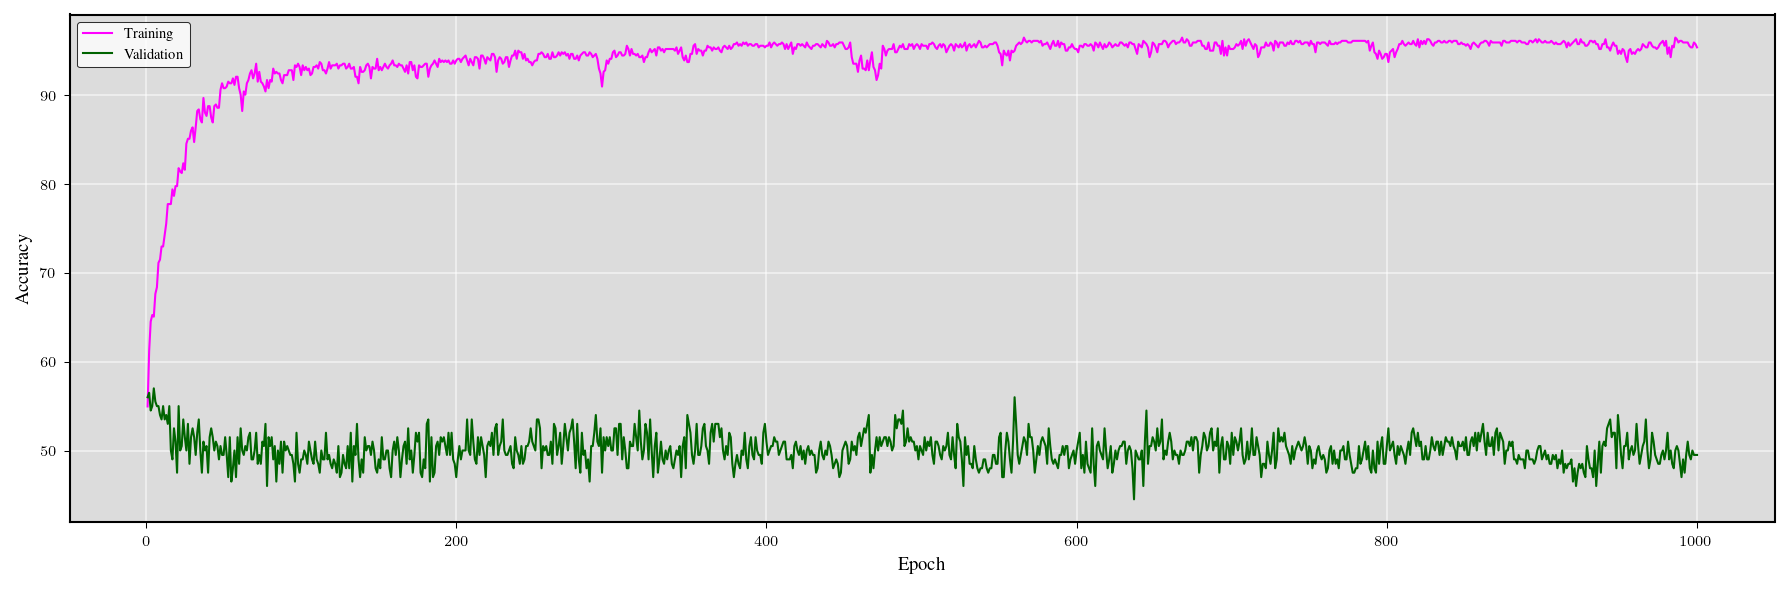

In [119]:
fig, ax = plt.subplots(figsize=(12,4))

ax.set_facecolor('gainsboro')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='white', axis='x', linestyle='-', linewidth=1, alpha=0.5)
ax.grid(color='white', axis='y', linestyle='-', linewidth=1, alpha=0.5)

epochs_train = len(training_accuracy_list)
epochs_val = len(validation_accurary_list)

plt.plot(np.arange(1, epochs_train+1),training_accuracy_list, label='Training',color='magenta')
plt.plot(np.arange(1, epochs_val+1),validation_accurary_list, label='Validation',color='darkgreen')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

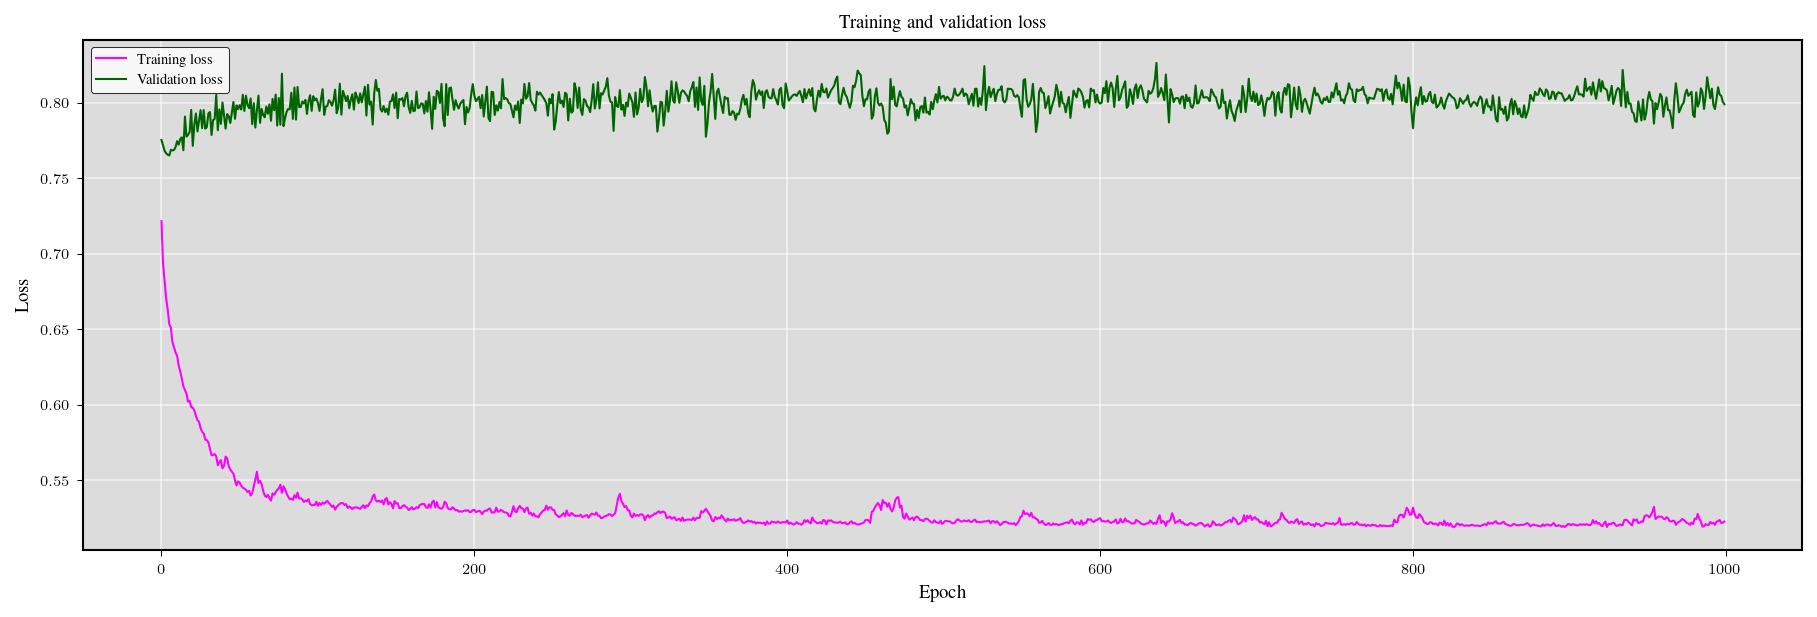

In [120]:
# Plot training and validation losses 

# Use to plots to clean up the presentation 
from tueplots import bundles 
from tueplots import figsizes
from tueplots import axes

# tueplots paramaters 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(axes.lines())
figsizes.neurips2021(nrows=3)["figure.figsize"]

plt.rcParams.update({"figure.dpi": 150})

fig, ax = plt.subplots(figsize=(12,4))

ax.set_facecolor('gainsboro')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='white', axis='x', linestyle='-', linewidth=1, alpha=0.5)
ax.grid(color='white', axis='y', linestyle='-', linewidth=1, alpha=0.5)

ax.plot(training_loss_list, label='Training loss',color='magenta')
ax.plot(validation_loss_list, label='Validation loss',color = 'darkgreen')


ax.set_title(' Training and validation loss ')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')


ax.legend()


plt.show

